In [1]:
import jetnet
from jetnet.datasets import JetNet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle
import plotting
from typing import OrderedDict

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/jet_plots/Nov2"
_ = os.system(f"mkdir -p {plot_dir}")

data_dir = "../saved_data/"


## Distributions

In [4]:
truth_jets_pf, _ = JetNet.getData(
    "g",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[1.0, 0, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)


In [47]:
q_efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])

In [25]:
t_efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])

KeyboardInterrupt: 

In [5]:
# efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
# np.save("efps", efps)


In [5]:
efps_true = np.load(f"{data_dir}/efps_true.npy")
pnet_activations_true = np.load(f"{data_dir}/pnet_activations_true.npy")


In [37]:
real_efps = efps_true

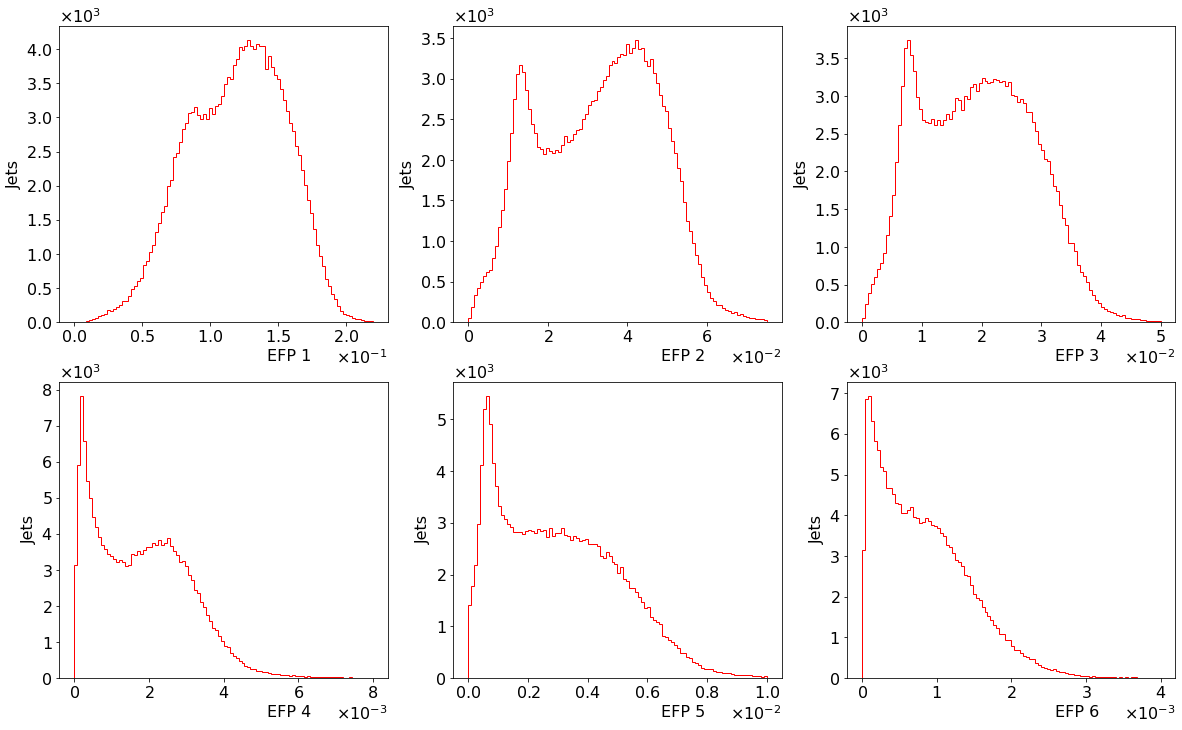

In [56]:
jet_type = "t"

if jet_type == "g":
    binranges = [0.2, 0.06, 0.04, 0.003, 0.003, 0.0015]
elif jet_type == "q":
    binranges = [0.2, 0.06, 0.04, 0.003, 0.003, 0.0015]
else:
    binranges = [0.22, 0.075, 0.05, 0.008, 0.01, 0.004]

efp_indices = [1, 2, 5, 8, 13, 18, 32]

bins = [np.linspace(0, binr, 101) for binr in binranges]

fig = plt.figure(figsize=(20, 12))
for i in range(6):
    fig.add_subplot(2, 3, i + 1)
    plt.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(axis="x", scilimits=(0, 0), useMathText=True)
    _ = plt.hist(
        t_efps[:, efp_indices[i]], bins[i], histtype="step", label="Real", color="red"
    )
    plt.xlabel("EFP " + str(i + 1), x=0.7)
    plt.ylabel("Jets")

In [10]:
from coffea.lookup_tools.dense_lookup import dense_lookup

mass = jetnet.utils.jet_features(truth_jets_pf[:, :, :3])["mass"]

np.random.seed(4)

bins = np.linspace(0, np.max(mass), 26)
true_mass_hist = np.histogram(mass, bins)[0]

smeared_hist = np.histogram(mass * np.random.normal(1, 0.25, size=mass.shape), bins)[0]
shifted_hist = np.histogram(mass * np.random.normal(1.1, 0.05, size=mass.shape), bins)[0]

smeared_lookup = dense_lookup(smeared_hist / true_mass_hist, bins)
shifted_lookup = dense_lookup(shifted_hist / true_mass_hist, bins)

smeared_weights = smeared_lookup(mass)
smeared_weights /= np.sum(smeared_weights)

shifted_weights = shifted_lookup(mass)
shifted_weights /= np.sum(shifted_weights)

tailcut_weights = (mass < 0.17).astype(float)
tailcut_weights /= np.sum(tailcut_weights)

dists = OrderedDict(
    [
        ("truth", (np.ones(truth_jets_pf.shape[0]) / truth_jets_pf.shape[0], "Truth")),
        ("smeared", (smeared_weights, "Smeared")),
        ("shifted", (shifted_weights, "Shifted")),
        ("tailcut", (tailcut_weights, "Removing Tail")),
    ]
)


In [9]:
# np.random.seed(4)

# pf_dists = OrderedDict()

# pf_dists["all_smeared"] = (
#     truth_jets_pf * np.random.normal(1, 0.25, size=truth_jets_pf.shape),
#     "Particle Features Smeared",
# )
# pf_dists["eta_smeared"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., 0:1] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 0:1].shape),
#             truth_jets_pf[..., 1:],
#         ),
#         axis=-1,
#     ),
#     r"Particle $\eta^{rel}$ Smeared",
# )
# pf_dists["pt_smeared"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., :2],
#             truth_jets_pf[..., 2:3] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 2:3].shape),
#         ),
#         axis=-1,
#     ),
#     r"Particle $p_T^{rel}$ Smeared",
# )
# pf_dists["pt_shifted"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., :2],
#             truth_jets_pf[..., 2:3]
#             * np.random.normal(0.9, 0.1, size=truth_jets_pf[..., 2:3].shape),
#         ),
#         axis=-1,
#     ),
#     r"Particle $p_T^{rel}$ Shifted",
# )


In [31]:
# with open("pf_dists.pkl", "wb") as f:
#     pickle.dump(pf_dists, f)


In [28]:
# efps = {
#     key: jetnet.utils.efps(jets, efpset_args=[("d<=", 4)]) for key, (jets, _) in pf_dists.items()
# }
#
# with open("efps_dict.pkl", "wb") as f:
#     pickle.dump(efps, f)


In [7]:
with open(f"{data_dir}/pf_dists.pkl", "rb") as f:
    pf_dists = pickle.load(f)

with open(f"{data_dir}/efps_dict.pkl", "rb") as f:
    efps = pickle.load(f)

pnet_activations = {}

for key in pf_dists:
    pnet_activations[key] = np.load(f"{data_dir}/pnet_activations_{key}.npy")

masses = {key: jetnet.utils.jet_features(jets)["mass"] for key, (jets, _) in pf_dists.items()}


## Plot Distributions

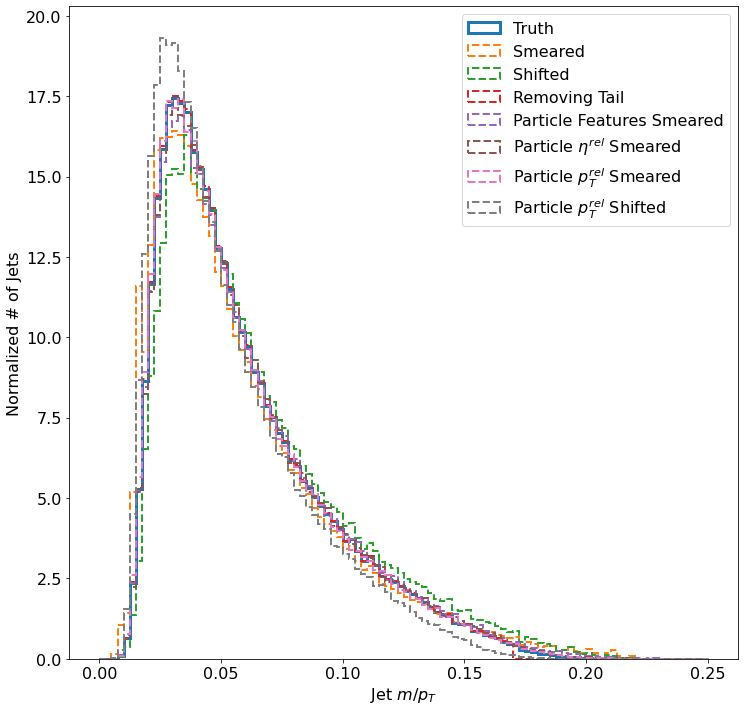

In [13]:
plt.figure(figsize=(12, 12))

bins = np.linspace(0, 0.25, 101)

_ = plt.hist(mass, bins, histtype="step", label="Truth", linewidth=3, density=True)
for weights, label in dists.values():
    if label == "Truth":
        continue
    
    _ = plt.hist(
        mass,
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        masses[key],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists.pdf", bbox_inches="tight")


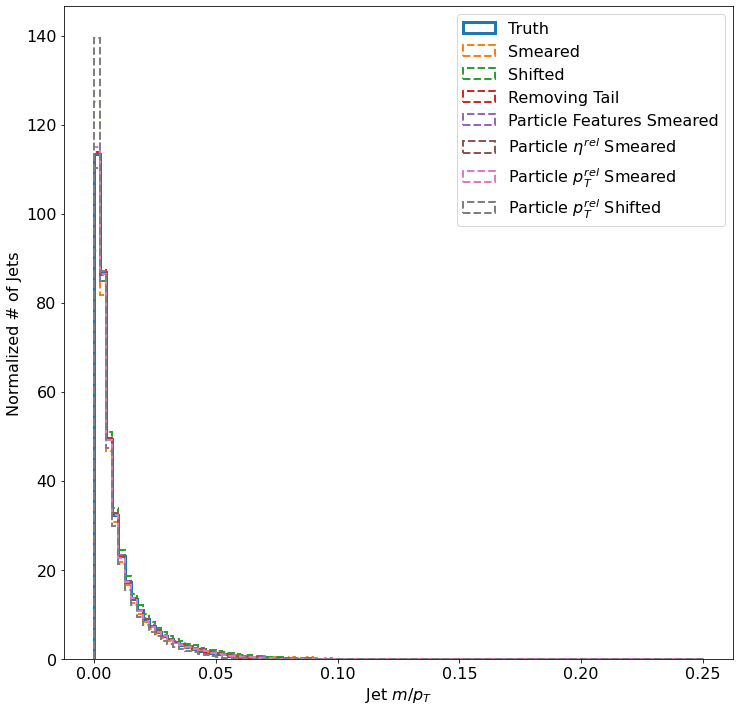

In [19]:
plt.figure(figsize=(12, 12))

# bins = np.linspace(0, 0.04, 101)
bins = np.linspace(0, 0.25, 101)
efp_index = 2

_ = plt.hist(
    efps_true[:, efp_index], bins, histtype="step", label="Truth", linewidth=3, density=True
)
for weights, label in dists.values():
    if label == "Truth":
        continue

    _ = plt.hist(
        efps_true[:, efp_index],
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        efps[key][:, efp_index],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists_efp.pdf", bbox_inches="tight")


## Measurements

In [14]:
num_samples = 150_000
sample_efps = OrderedDict()
sample_acts = OrderedDict()
sample_masses = OrderedDict()

np.random.seed(4)
true_inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
true_mass = mass[true_inds]
true_efps = efps_true[true_inds]
true_acts = pnet_activations_true[true_inds]

for key, (weights, _) in dists.items():
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples, p=weights)
    sample_masses[key] = mass[inds]
    sample_efps[key] = efps_true[inds]
    sample_acts[key] = pnet_activations_true[inds]
    # np.save(f"../distorted_jets/{key}.npy", truth_jets_pf[inds])

for key in pf_dists:
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
    sample_masses[key] = masses[key][inds]
    sample_efps[key] = efps[key][inds]
    sample_acts[key] = pnet_activations[key][inds]
    # np.save(f"../distorted_jets/{key}.npy", pf_dists[key][0])


In [15]:
num_batches = 5

batch_sizes = {
    "w1m": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
    ],
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000],
    "fgd": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
    ],
    "fgd_inf": [10_000, 15_000, 20_000, 25_000, 30_000, 40_000, 50_000],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000],
}

metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {"normalise": False}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        ("fgd_inf", (gen_metrics.frechet_gaussian_distance, {}, r"$\mathrm{FGD}_{\infty}$")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD Poly Deg=4 Quadratic Unbiased Est.",
            ),
        ),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
    ]
)


### W1m

In [11]:
measurements_w1m = OrderedDict()
mkey = "w1m"

for dkey in sample_masses:
    print(dkey)
    ms = []
    ts = []
    for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
        mean_std, timing = gen_metrics.multi_batch_evaluation(
            true_mass,
            sample_masses[dkey],
            num_batches,
            batch_size,
            gen_metrics.wasserstein1d,
            timing=True,
        )
        ms.append(mean_std)
        ts.append(timing)
    measurements_w1m[dkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.82it/s] 


smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.71it/s] 


shifted


w1m: 100%|██████████| 18/18 [00:00<00:00, 34.65it/s] 


tailcut


w1m: 100%|██████████| 18/18 [00:00<00:00, 34.12it/s] 


all_smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.03it/s] 


eta_smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 30.68it/s] 


pt_smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 34.17it/s] 


pt_shifted


w1m: 100%|██████████| 18/18 [00:00<00:00, 32.25it/s] 


### EFPs

In [31]:
if "measurements_efps" not in locals():
    measurements_efps = OrderedDict()

for dkey in sample_efps:
    print(dkey)
    if dkey not in measurements_efps:
        measurements_efps[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements_efps[dkey] or mkey == "fgd_inf":
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_efps,
                sample_efps[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args
            )
            ms.append(mean_std)
            ts.append(timing)

        measurements_efps[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


fgd: 100%|██████████| 18/18 [00:02<00:00,  8.99it/s]


smeared


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.45it/s]


shifted


fgd: 100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


tailcut


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.33it/s]


all_smeared


fgd: 100%|██████████| 18/18 [00:02<00:00,  8.78it/s]


eta_smeared


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.26it/s]


pt_smeared


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


pt_shifted


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


#### FGD Infinity

In [30]:
mkey = "fgd_inf"

for dkey in sample_efps:
    ms = []
    for n in batch_sizes[mkey]:
        ms.append(gen_metrics.one_over_n_extrapolation(true_efps, sample_efps[dkey], gen_metrics.frechet_gaussian_distance, num_samples=n))

    measurements_efps[dkey][mkey] = {"mean_std": np.array(ms)}
    

### ParticleNet Activations

In [34]:
if "measurements_acts" not in locals():
    measurements_acts = OrderedDict()

for dkey in sample_acts:
    print(dkey)
    if dkey not in measurements_acts:
        measurements_acts[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (mkey in measurements_acts[dkey]) or mkey == "fgd_inf":
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_acts,
                sample_acts[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args,
                normalise=False
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements_acts[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.25it/s]


shifted


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


tailcut


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


all_smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.02it/s]


eta_smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]


pt_smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]


pt_shifted


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]


#### FGD Infinity

In [31]:
mkey = "fgd_inf"

for dkey in sample_acts:
    print(dkey)
    ms = []
    for n in tqdm(batch_sizes[mkey]):
        ms.append(gen_metrics.one_over_n_extrapolation(true_acts, sample_acts[dkey], gen_metrics.frechet_gaussian_distance, num_samples=n))

    measurements_acts[dkey][mkey] = {"mean_std": np.array(ms)}
    

truth


100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


smeared


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


shifted


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


tailcut


100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


all_smeared


100%|██████████| 7/7 [00:21<00:00,  3.09s/it]


eta_smeared


100%|██████████| 7/7 [00:20<00:00,  2.94s/it]


pt_smeared


100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


pt_shifted


100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


In [32]:
# with open(f"{plot_dir}/measurements_w1m.pkl", "wb") as f:
#     pickle.dump(measurements_w1m, f)

# with open(f"{plot_dir}/measurements_efps.pkl", "wb") as f:
#     pickle.dump(measurements_efps, f)

# with open(f"{plot_dir}/measurements_acts.pkl", "wb") as f:
#     pickle.dump(measurements_acts, f)


In [16]:
measurements_dir = "../plots/jet_plots/Oct26"

with open(f"{measurements_dir}/measurements_w1m.pkl", "rb") as f:
    measurements_w1m = pickle.load(f)

with open(f"{measurements_dir}/measurements_efps.pkl", "rb") as f:
    measurements_efps = pickle.load(f)

with open(f"{measurements_dir}/measurements_acts.pkl", "rb") as f:
    measurements_acts = pickle.load(f)

## Plot Measurements

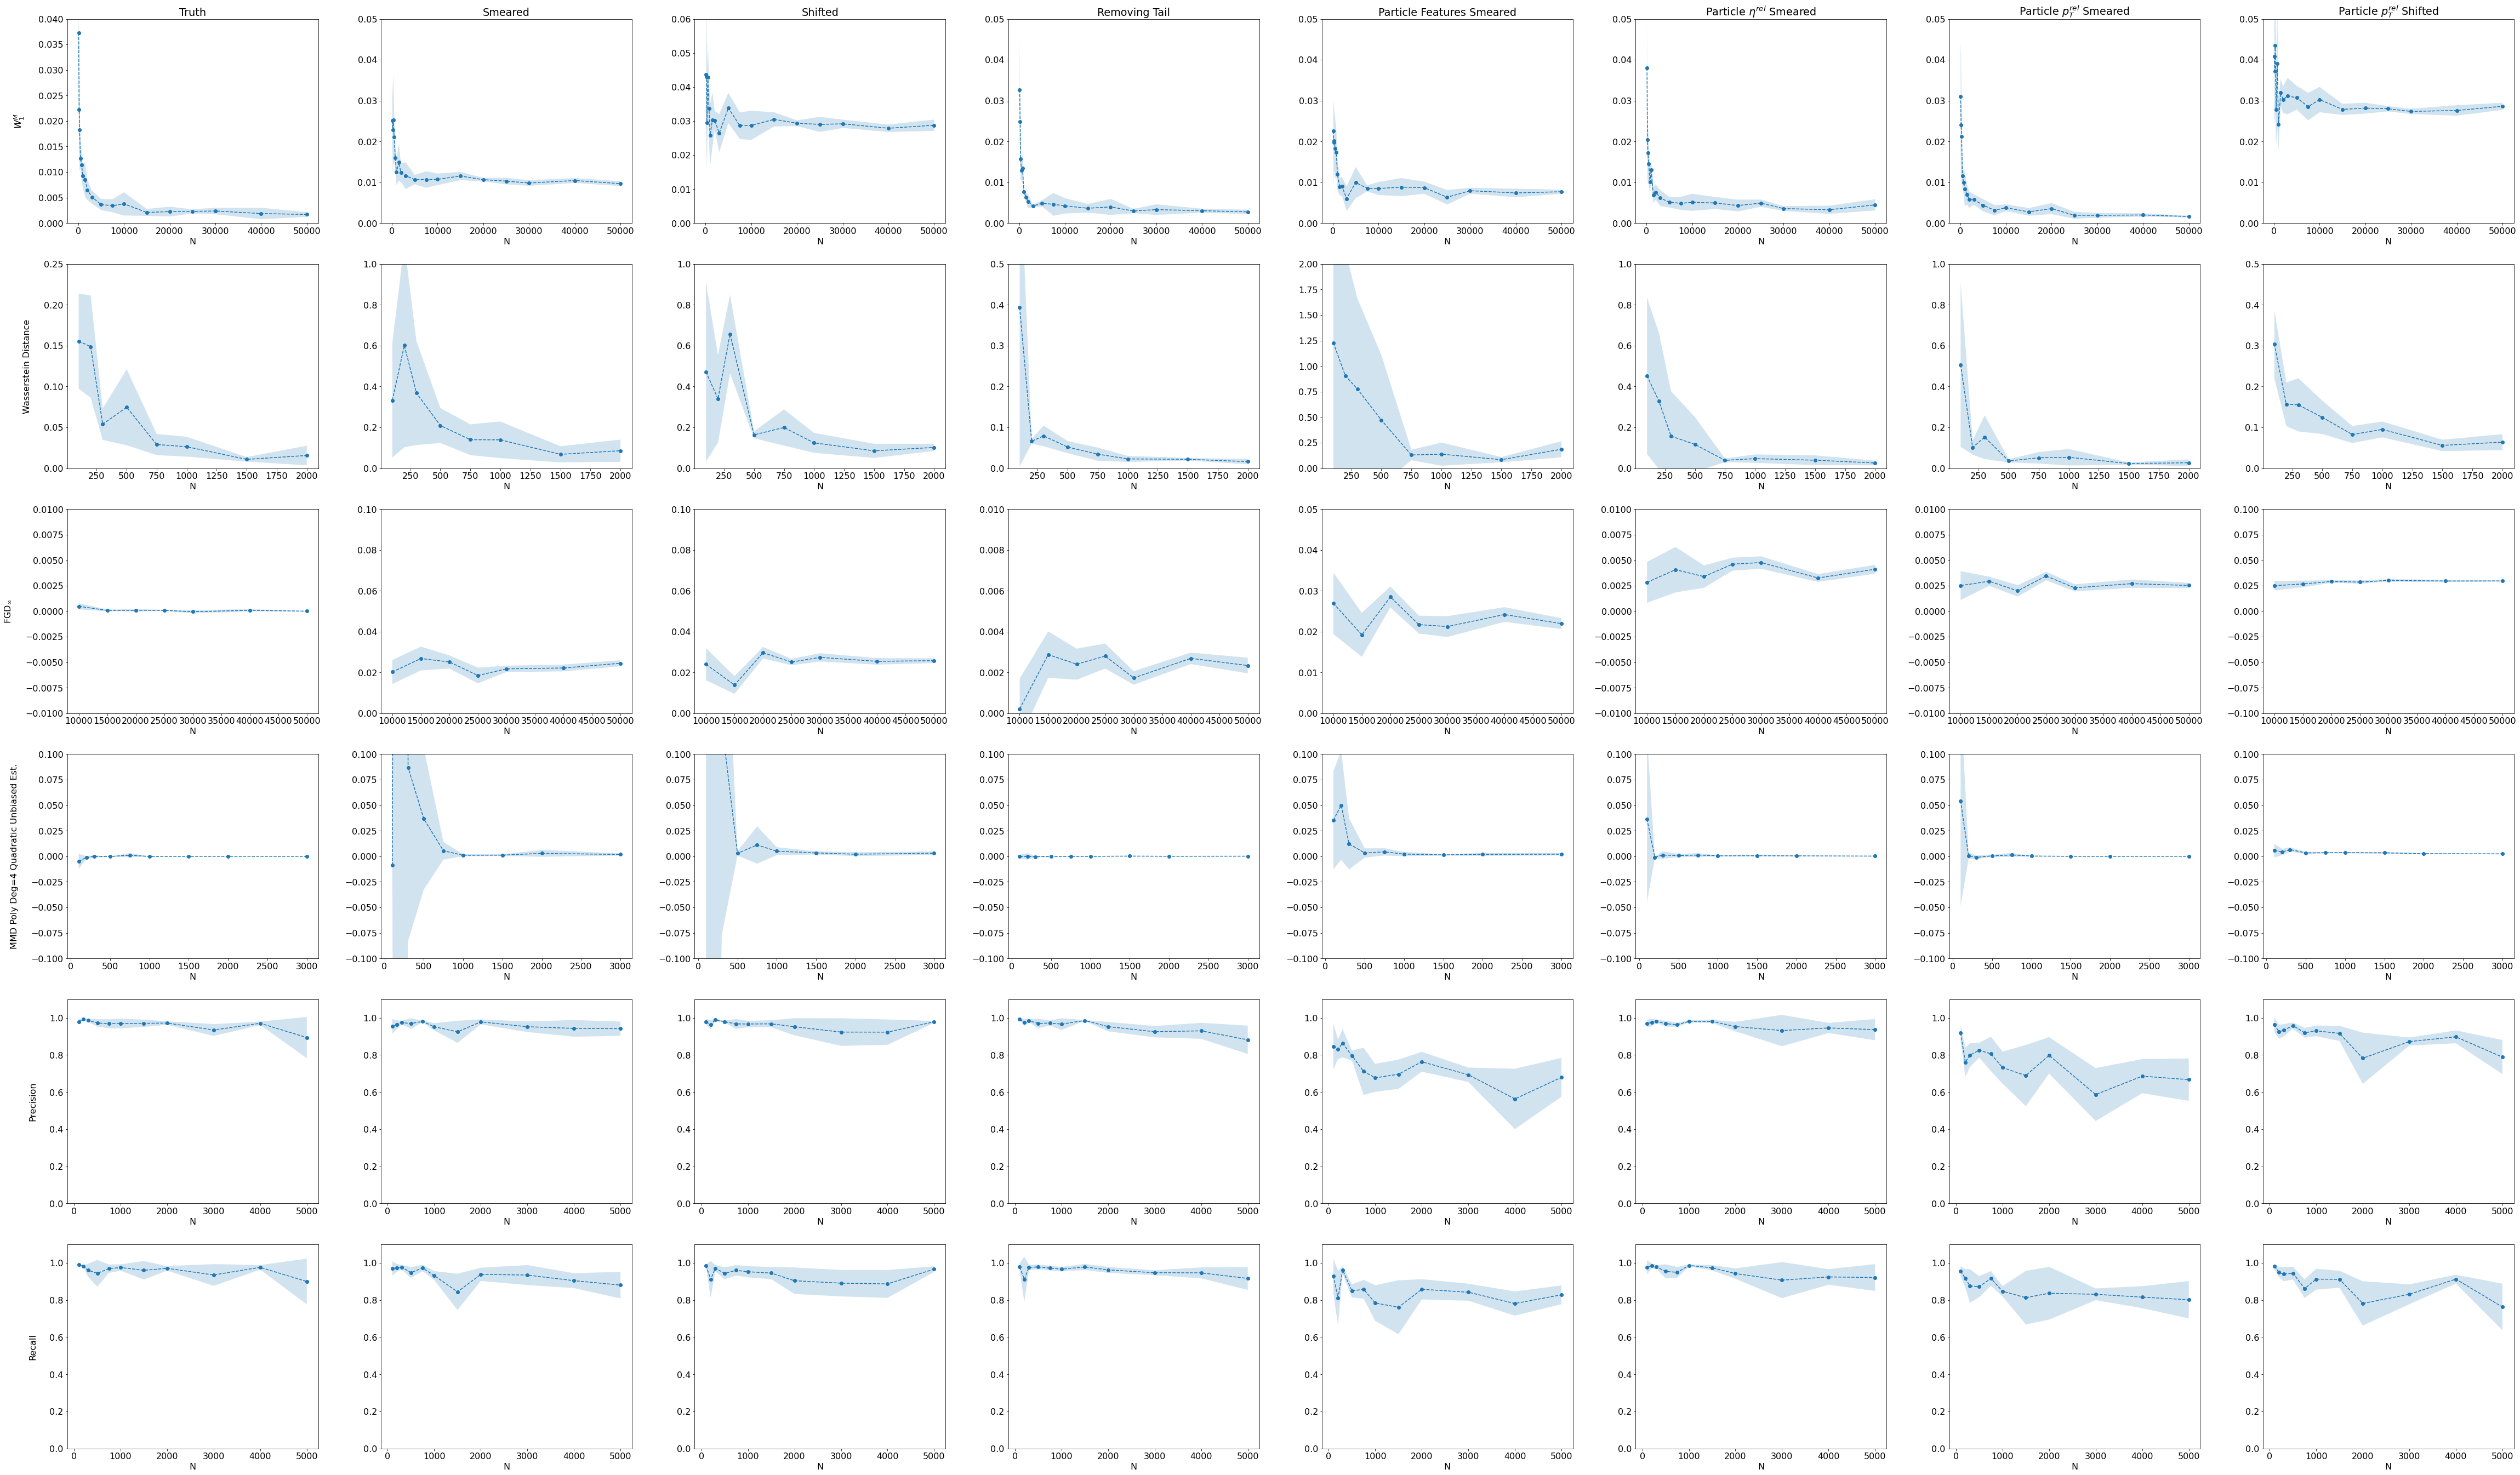

In [19]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("w1m", ([0, 0.04], [0, 0.05], [0, 0.06], [0, 0.05], [0, 0.05], [0, 0.05], [0, 0.05], [0, 0.05])),
        ("wasserstein", ([0, 0.25], [0, 1], [0, 1], [0, 0.5], [0, 2], [0, 1], [0, 1], [0, 0.5])),
        # (
        #     "fgd",
        #     ([0, 0.25], [0, 0.5], [0, 1], [0, 0.1], [0, 0.25], [0, 0.25], [0, 0.15], [0, 0.25]),
        # ),
        (
            "fgd_inf",
            ([-0.01, 0.01], [0, 0.1], [0, 0.1], [0, 0.01], [0, 0.05], [-0.01, 0.01], [-0.01, 0.01], [-0.1, 0.1]),
        ),
        (
            "mmdup4",
            (
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
            ),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

i = 0
mkey = "w1m"
plotting.metric_label(axes[i][0], r"$W_1^M$")
for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
    axes[i][j].set_title(label)
    plotting.plot_means_stds(
        axes[i][j], measurements_w1m[dkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
    )

for (mkey, (metric, metric_args, label)) in metrics.items():
    if mkey in ["dc", "pr"] or mkey not in ylims:
        continue

    i = list(ylims.keys()).index(mkey)

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        plotting.plot_means_stds(
            axes[i][j], measurements_efps[dkey][mkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, dkey in enumerate(dists | pf_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements_efps[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )


plt.savefig(f"{plot_dir}/efps_scores.pdf", bbox_inches="tight")


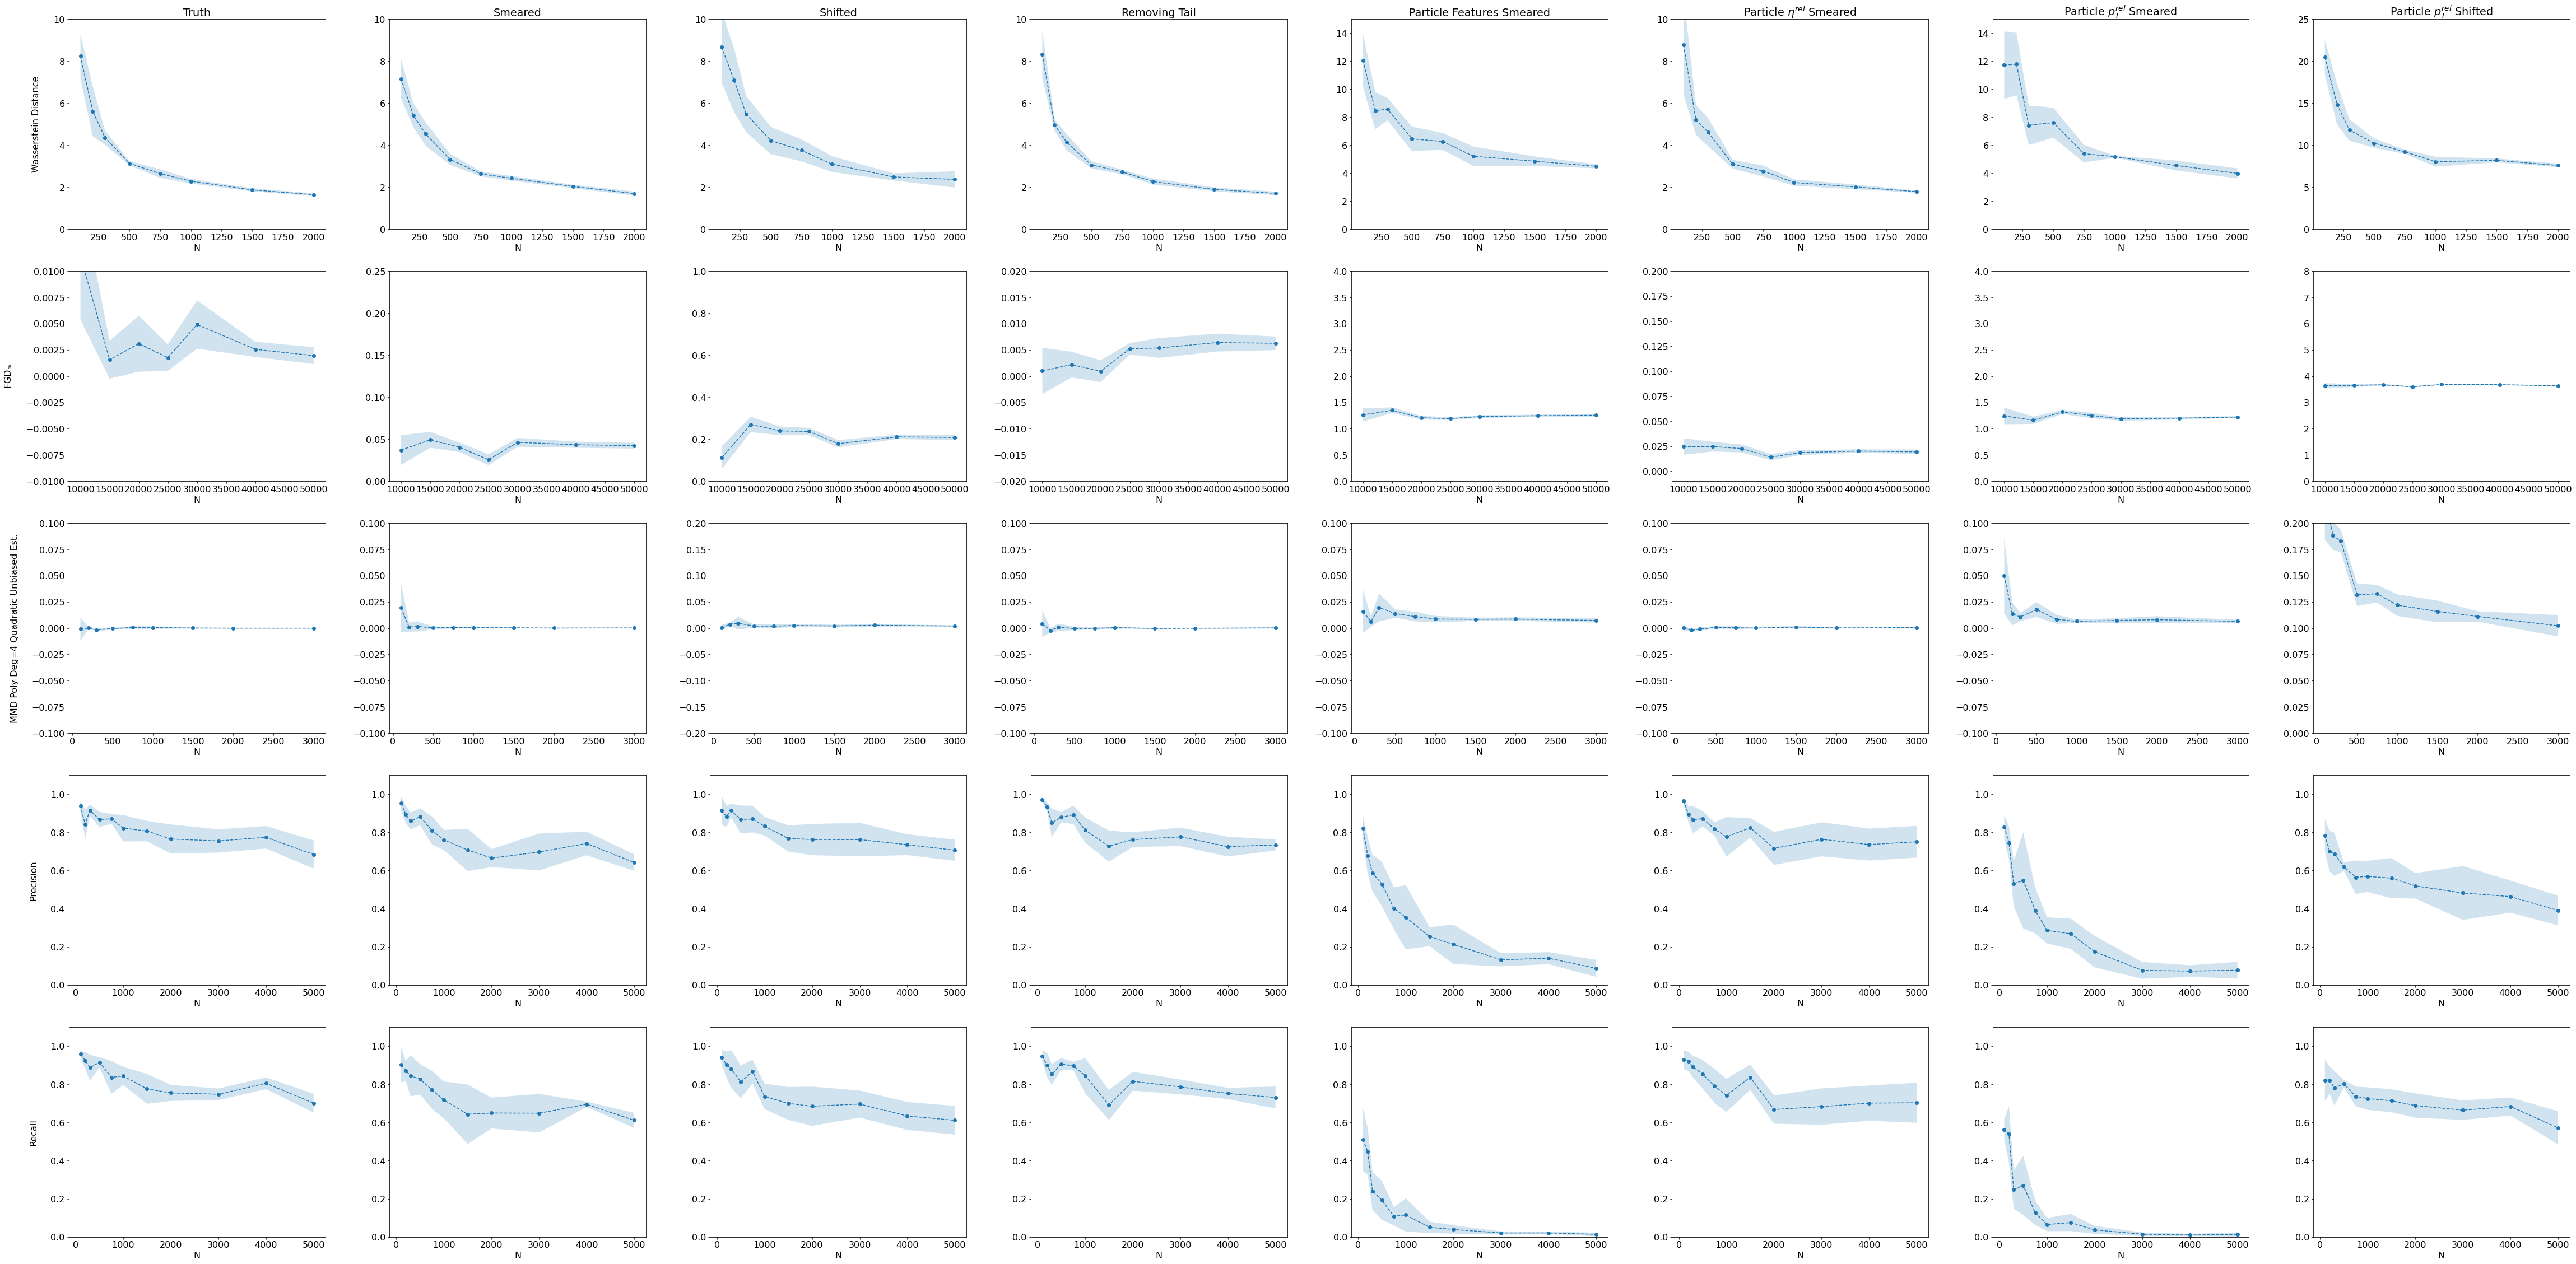

In [21]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 10], [0, 10], [0, 10], [0, 10], [0, 15], [0, 10], [0, 15], [0, 25])),
        # ("fgd", ([0, 2], [0, 2], [0, 2], [0, 2], [0, 5], [0, 2], [0, 8], [0, 10])),
        (
            "fgd_inf",
            ([-0.01, 0.01], [0, 0.25], [0, 1], [-0.02, 0.02], [0, 4], [-0.01, 0.2], [0, 4], [0, 8]),
        ),
        (
            "mmdup4",
            (
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.2, 0.2],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [0, 0.2],
            ),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for (mkey, (metric, metric_args, label)) in metrics.items():
    if mkey in ["dc", "pr"] or mkey not in ylims:
        continue

    i = list(ylims.keys()).index(mkey)

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        plotting.plot_means_stds(
            axes[i][j], measurements_acts[dkey][mkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, dkey in enumerate(dists | pf_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements_acts[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )

plt.savefig(f"{plot_dir}/acts_scores.pdf", bbox_inches="tight")


# Table of values

In [22]:
def print_mean_std(mean_stds: np.ndarray):
    return f"{mean_stds[0]:.3f} ± {mean_stds[1]:.3f}"

rows = []

row = [r"$W_1^M$"]
for dkey, values in measurements_w1m.items():
    row.append(print_mean_std(values['mean_std'][-1, :]))

rows.append(row)

for mkey, (metric, metric_args, label) in metrics.items():
    if mkey == "fgd":
        continue

    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " EFP"]

            for dkey, values in measurements_efps.items():
                row.append(print_mean_std(values[mkey]['mean_std'][-1, :, i]))

            rows.append(row)
        # continue
    else:
        row = [label + " EFP"]

        for dkey, values in measurements_efps.items():
            row.append(print_mean_std(values[mkey]['mean_std'][-1, :]))

        rows.append(row)

for mkey, (metric, metric_args, label) in metrics.items():
    if mkey == "fgd":
        continue
    
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " PNet Activations"]

            for dkey, values in measurements_acts.items():
                row.append(print_mean_std(values[mkey]['mean_std'][-1, :, i]))

            rows.append(row)
        # continue
    else:
        row = [label + " PNet Activations"]

        for dkey, values in measurements_acts.items():
            row.append(print_mean_std(values[mkey]['mean_std'][-1, :]))

        rows.append(row)

# https://graphgan.nrp-nautilus.io/hep-generative-metrics/classifier_trainings/
pnet_aucs = [0.5009051928, 0.5245543864000001, 0.5431707766, 0.5030471778, 0.9721441670000002, 0.8120980804, 0.934389781, 0.9887714117999998]
rows.append(["Classifier AUC"] + [f"{auc:.2f}" for auc in pnet_aucs])

results = pd.DataFrame(
    rows, columns=["Metric"] + list(np.array(list((dists | pf_dists).values()), dtype=object)[:, 1])
)

display(Markdown(results.to_markdown()))


|    | Metric                                                  | Truth          | Smeared       | Shifted       | Removing Tail   | Particle Features Smeared   | Particle $\eta^{rel}$ Smeared   | Particle $p_T^{rel}$ Smeared   | Particle $p_T^{rel}$ Shifted   |
|---:|:--------------------------------------------------------|:---------------|:--------------|:--------------|:----------------|:----------------------------|:--------------------------------|:-------------------------------|:-------------------------------|
|  0 | $W_1^M$                                                 | 0.002 ± 0.000  | 0.010 ± 0.001 | 0.029 ± 0.002 | 0.003 ± 0.001   | 0.008 ± 0.001               | 0.004 ± 0.001                   | 0.002 ± 0.000                  | 0.029 ± 0.001                  |
|  1 | Wasserstein Distance EFP                                | 0.016 ± 0.012  | 0.086 ± 0.054 | 0.102 ± 0.018 | 0.016 ± 0.007   | 0.186 ± 0.079               | 0.026 ± 0.011                   | 0.027 ± 0.016                  | 0.064 ± 0.020                  |
|  2 | $\mathrm{FGD}_{\infty}$ EFP                             | 0.000 ± 0.000  | 0.025 ± 0.001 | 0.026 ± 0.001 | 0.002 ± 0.000   | 0.022 ± 0.001               | 0.004 ± 0.000                   | 0.003 ± 0.000                  | 0.030 ± 0.001                  |
|  3 | MMD Poly Deg=4 Quadratic Unbiased Est. EFP              | -0.000 ± 0.000 | 0.002 ± 0.001 | 0.003 ± 0.002 | 0.000 ± 0.000   | 0.002 ± 0.001               | 0.000 ± 0.000                   | 0.000 ± 0.000                  | 0.002 ± 0.000                  |
|  4 | Precision EFP                                           | 0.894 ± 0.111  | 0.941 ± 0.039 | 0.978 ± 0.005 | 0.882 ± 0.077   | 0.680 ± 0.104               | 0.936 ± 0.057                   | 0.667 ± 0.114                  | 0.789 ± 0.092                  |
|  5 | Recall EFP                                              | 0.900 ± 0.123  | 0.881 ± 0.072 | 0.967 ± 0.015 | 0.916 ± 0.062   | 0.828 ± 0.050               | 0.921 ± 0.072                   | 0.802 ± 0.101                  | 0.763 ± 0.125                  |
|  6 | Wasserstein Distance PNet Activations                   | 1.646 ± 0.063  | 1.699 ± 0.096 | 2.372 ± 0.388 | 1.708 ± 0.082   | 4.492 ± 0.145               | 1.789 ± 0.050                   | 3.986 ± 0.362                  | 7.595 ± 0.219                  |
|  7 | $\mathrm{FGD}_{\infty}$ PNet Activations                | 0.002 ± 0.001  | 0.042 ± 0.003 | 0.208 ± 0.013 | 0.006 ± 0.001   | 1.256 ± 0.028               | 0.019 ± 0.002                   | 1.222 ± 0.017                  | 3.635 ± 0.019                  |
|  8 | MMD Poly Deg=4 Quadratic Unbiased Est. PNet Activations | -0.000 ± 0.000 | 0.000 ± 0.000 | 0.004 ± 0.001 | 0.000 ± 0.001   | 0.007 ± 0.002               | 0.001 ± 0.000                   | 0.006 ± 0.002                  | 0.102 ± 0.010                  |
|  9 | Precision PNet Activations                              | 0.684 ± 0.074  | 0.642 ± 0.043 | 0.706 ± 0.056 | 0.734 ± 0.029   | 0.088 ± 0.044               | 0.751 ± 0.083                   | 0.078 ± 0.043                  | 0.390 ± 0.078                  |
| 10 | Recall PNet Activations                                 | 0.701 ± 0.049  | 0.611 ± 0.039 | 0.612 ± 0.075 | 0.731 ± 0.058   | 0.014 ± 0.009               | 0.703 ± 0.105                   | 0.014 ± 0.011                  | 0.572 ± 0.087                  |
| 11 | Classifier AUC                                          | 0.50           | 0.52          | 0.54          | 0.50            | 0.97                        | 0.81                            | 0.93                           | 0.99                           |

In [5]:
gen_jets = np.load("/Users/raghav/Downloads/best_epoch_gen_jets-2.npy")

In [6]:
gen_efps = jetnet.utils.efps(gen_jets, efpset_args=[("d<=", 4)])

In [7]:
real_efps = np.load("/Users/raghav/Downloads/t.npy")

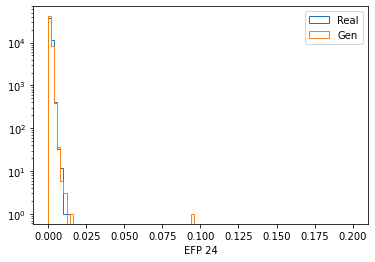

In [8]:
_ = plt.hist(real_efps[:, 24], np.linspace(0, 0.2, 101), histtype='step', label="Real")
_ = plt.hist(gen_efps[:, 24], np.linspace(0, 0.2, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel("EFP 24")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

In [9]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

def linear(x, intercept, slope):
    return intercept + slope * x

In [14]:
numb = 10
nump = 200

means_ses = []
for i in tqdm(range(10)):
    res = gen_metrics.one_over_n_extrapolation_repeated_measurements(real_efps, gen_efps, gen_metrics.frechet_gaussian_distance, min_samples=5000, max_samples=50_000, num_batches=numb, num_points=nump, seed=i)
    means_ses.append([res[0][0], res[1][0]])

100%|██████████| 10/10 [03:33<00:00, 21.30s/it]


In [18]:
import numpy as np

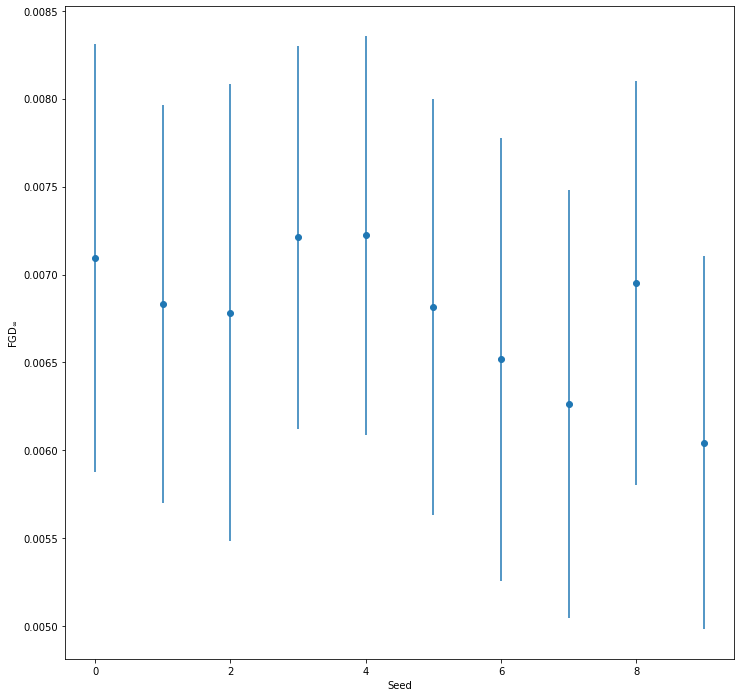

In [19]:
means_ses = np.array(means_ses)
plt.figure(figsize=(12, 12))
plt.errorbar(range(10), means_ses[:, 0], means_ses[:, 1], fmt="o")
plt.ylabel(r"FGD$_\infty$")
plt.xlabel("Seed")
plt.savefig(f"{plot_dir}/fgdinf_check_b{numb}_p{nump}.pdf")

In [47]:
res = gen_metrics.one_over_n_extrapolation(real_efps, gen_efps, gen_metrics.frechet_gaussian_distance, min_samples=5_000, max_samples=25_000, num_batches=1, num_points=101, seed=1)
res

[-0.007852267142476775,
 0.0061213342358591655,
 array([ 5000,  5200,  5400,  5600,  5800,  6000,  6200,  6400,  6600,
         6800,  7000,  7200,  7400,  7600,  7800,  8000,  8200,  8400,
         8600,  8800,  9000,  9200,  9400,  9600,  9800, 10000, 10200,
        10400, 10600, 10800, 11000, 11200, 11400, 11600, 11800, 12000,
        12200, 12400, 12600, 12800, 13000, 13200, 13400, 13600, 13800,
        14000, 14200, 14400, 14600, 14800, 15000, 15200, 15400, 15600,
        15800, 16000, 16200, 16400, 16600, 16800, 17000, 17200, 17400,
        17600, 17800, 18000, 18200, 18400, 18600, 18800, 19000, 19200,
        19400, 19600, 19800, 20000, 20200, 20400, 20600, 20800, 21000,
        21200, 21400, 21600, 21800, 22000, 22200, 22400, 22600, 22800,
        23000, 23200, 23400, 23600, 23800, 24000, 24200, 24400, 24600,
        24800, 25000], dtype=int32),
 array([0.00235922, 0.09560776, 0.00388955, 0.00522308, 0.08261212,
        0.08481449, 0.00261556, 0.00331128, 0.07316306, 0.00343919

In [155]:
res = gen_metrics.one_over_n_extrapolation_repeated_measurements(real_efps, gen_efps, gen_metrics.frechet_gaussian_distance, min_samples=5000, max_samples=50_000, num_batches=20, num_points=20, seed=1)
res[0], res[1]


[30 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10]


(array([8.23640644e-03, 2.32230168e+01]),
 array([3.20304670e-03, 2.60780493e+01]))

In [146]:
val, cov = curve_fit(linear, 1 / res[0], res[1][:, 0], bounds=([0, 0], [np.inf, np.inf]))

In [117]:
regres = linregress(1 / res[0], res[1][:, 0])

In [147]:
val, np.sqrt(np.diag(cov))

(array([4.55959397e-03, 5.56087188e+01]),
 array([3.45844036e-03, 2.81573724e+01]))

In [119]:
regres.intercept, regres.intercept_stderr

(0.0060443597322654445, 0.0026849732279817864)

/var/folders/fh/cwyrvktn5bz76x4cpy_lbgnh0000gn/T/ipykernel_21947/3776030779.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.linspace(0, 50_000, 101), res[0][0] + res[0][1] * (1 / np.linspace(0, 50_000, 101)), color="red")


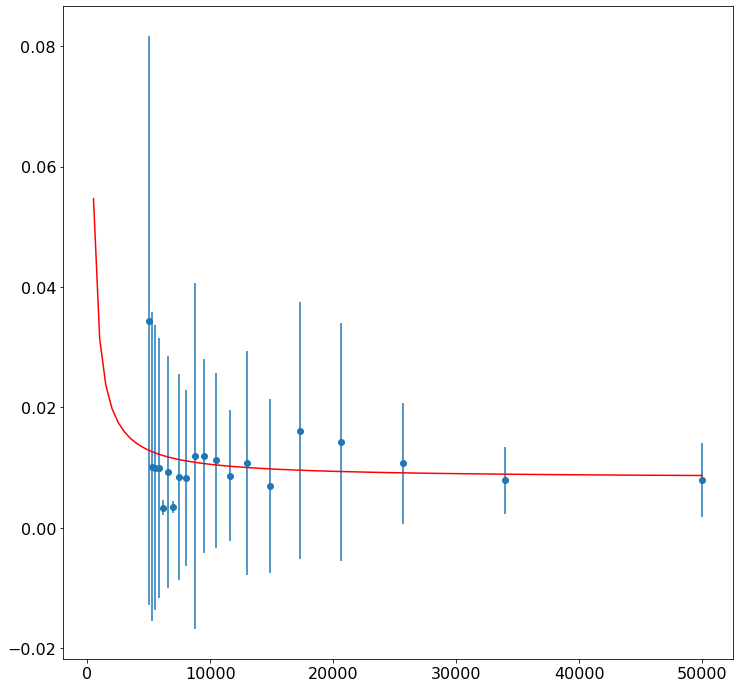

In [156]:
plt.figure(figsize=(12, 12))
plt.errorbar(res[2], res[3][:, 0], res[3][:, 1], fmt="o")
plt.plot(np.linspace(0, 50_000, 101), res[0][0] + res[0][1] * (1 / np.linspace(0, 50_000, 101)), color="red")
# plt.legend()

Text(0.5, 1.0, 'Without errors on measurements')

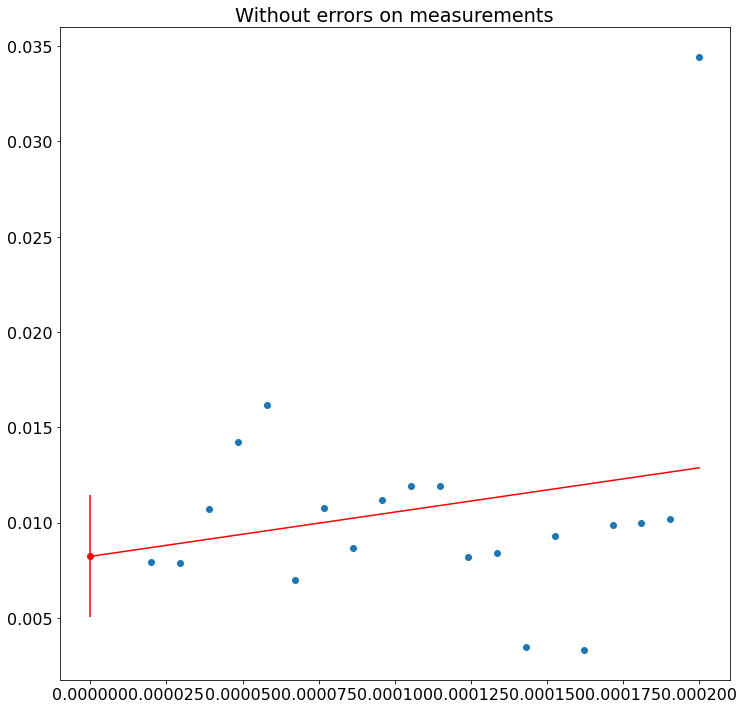

In [157]:
plt.figure(figsize=(12, 12))
# plt.errorbar(1 / res[0], res[1][:, 0], res[1][:, 1], fmt="o")
plt.scatter(1 / res[2], res[3][:, 0])
plt.plot(np.linspace(0, 0.0002, 101), res[0][0] + res[0][1] * np.linspace(0, 0.0002, 101), label="Full Fit", color="red")
plt.errorbar(0, res[0][0], res[1][0], fmt="o", color="red")
plt.title("Without errors on measurements")
# plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


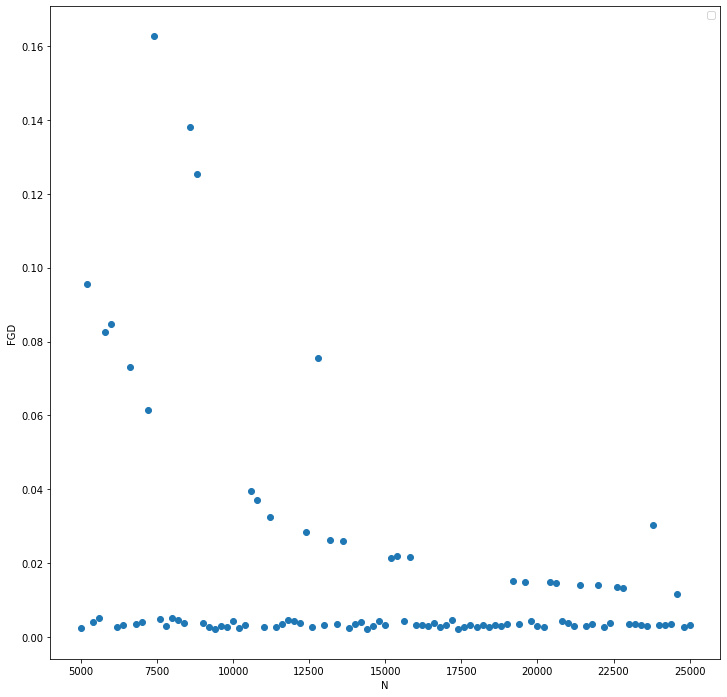

In [93]:
plt.figure(figsize=(12, 12))
plt.scatter(res[2], res[3])
# plt.plot(np.linspace(0, 0.0002, 101), res[0] + res[4] * np.linspace(0, 0.0002, 101), label="Full Fit", color="red")
# plt.plot(np.linspace(0, 0.0002, 101), val[0] + val[1] * np.linspace(0, 0.0002, 101), label="Averaged Fit", color="green")
# plt.errorbar(1 / np.mean(res[2][:-1].reshape(-1, 10), axis=1), np.mean(res[3][:-1].reshape(-1, 10), axis=1), np.std(res[3][:-1].reshape(-1, 10), axis=1), fmt="o", color="green")
# plt.errorbar(0, res[0], res[1], fmt="o", color="red")
# plt.errorbar(-0.000001, val[0], np.sqrt(np.diag(cov))[0], fmt="o", color="green")
plt.xlabel("N")
plt.ylabel("FGD")
plt.legend()

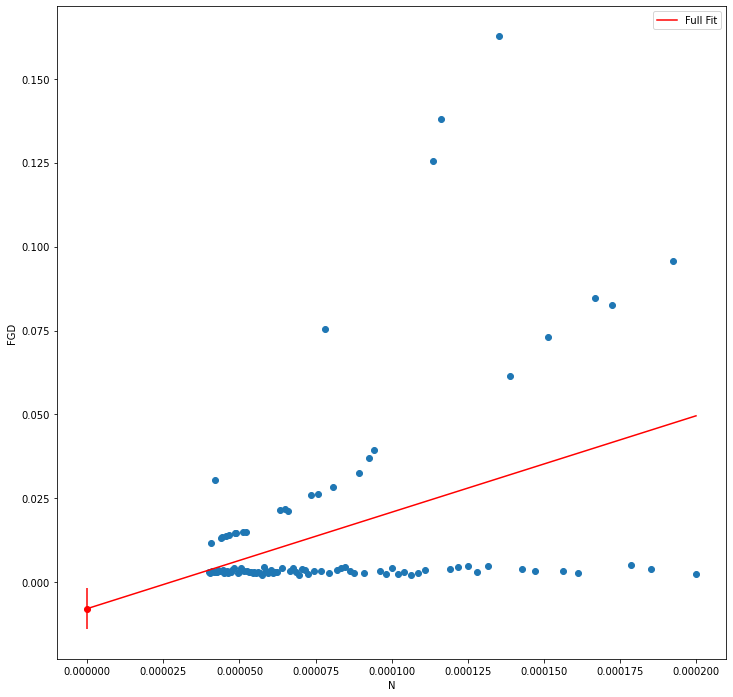

In [96]:
plt.figure(figsize=(12, 12))
plt.scatter(1 / res[2], res[3])
plt.plot(np.linspace(0, 0.0002, 101), res[0] + res[4] * np.linspace(0, 0.0002, 101), label="Full Fit", color="red")
# plt.plot(np.linspace(0, 0.0002, 101), val[0] + val[1] * np.linspace(0, 0.0002, 101), label="Averaged Fit", color="green")
# plt.errorbar(1 / np.mean(res[2][:-1].reshape(-1, 10), axis=1), np.mean(res[3][:-1].reshape(-1, 10), axis=1), np.std(res[3][:-1].reshape(-1, 10), axis=1), fmt="o", color="green")
plt.errorbar(0, res[0], res[1], fmt="o", color="red")
# plt.errorbar(-0.000001, val[0], np.sqrt(np.diag(cov))[0], fmt="o", color="green")
plt.xlabel("N")
plt.ylabel("FGD")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


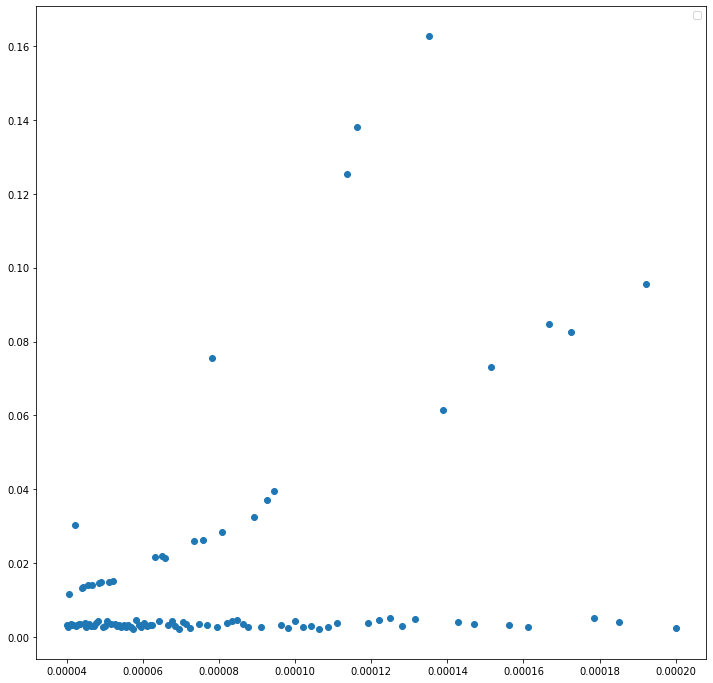

In [91]:
plt.figure(figsize=(12, 12))
plt.scatter(1 / res[2], res[3])
# plt.plot(np.linspace(0, 0.0002, 101), res[0] + res[4] * np.linspace(0, 0.0002, 101), label="Full Fit", color="red")
# plt.plot(np.linspace(0, 0.0002, 101), val[0] + val[1] * np.linspace(0, 0.0002, 101), label="Averaged Fit", color="green")
# plt.errorbar(1 / np.mean(res[2][:-1].reshape(-1, 10), axis=1), np.mean(res[3][:-1].reshape(-1, 10), axis=1), np.std(res[3][:-1].reshape(-1, 10), axis=1), fmt="o", color="green")
# plt.errorbar(0, res[0], res[1], fmt="o", color="red")
# plt.errorbar(-0.000001, val[0], np.sqrt(np.diag(cov))[0], fmt="o", color="green")
plt.legend()

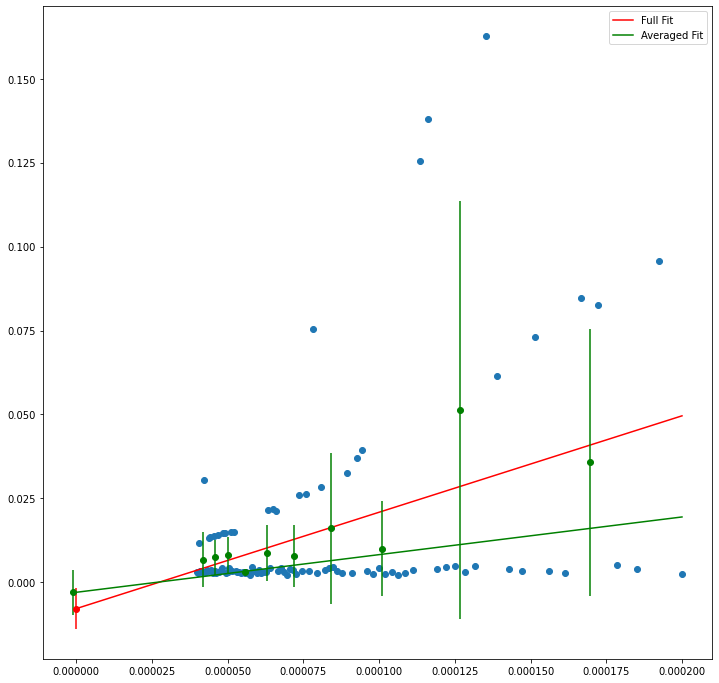

In [86]:
plt.figure(figsize=(12, 12))
plt.scatter(1 / res[2], res[3])
plt.plot(np.linspace(0, 0.0002, 101), res[0] + res[4] * np.linspace(0, 0.0002, 101), label="Full Fit", color="red")
plt.plot(np.linspace(0, 0.0002, 101), val[0] + val[1] * np.linspace(0, 0.0002, 101), label="Averaged Fit", color="green")
plt.errorbar(1 / np.mean(res[2][:-1].reshape(-1, 10), axis=1), np.mean(res[3][:-1].reshape(-1, 10), axis=1), np.std(res[3][:-1].reshape(-1, 10), axis=1), fmt="o", color="green")
plt.errorbar(0, res[0], res[1], fmt="o", color="red")
plt.errorbar(-0.000001, val[0], np.sqrt(np.diag(cov))[0], fmt="o", color="green")
plt.legend()

/var/folders/fh/cwyrvktn5bz76x4cpy_lbgnh0000gn/T/ipykernel_20213/1777573255.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.linspace(0, 50_000, 101), res[0] + res[4] * (1 / np.linspace(0, 50_000, 101)))


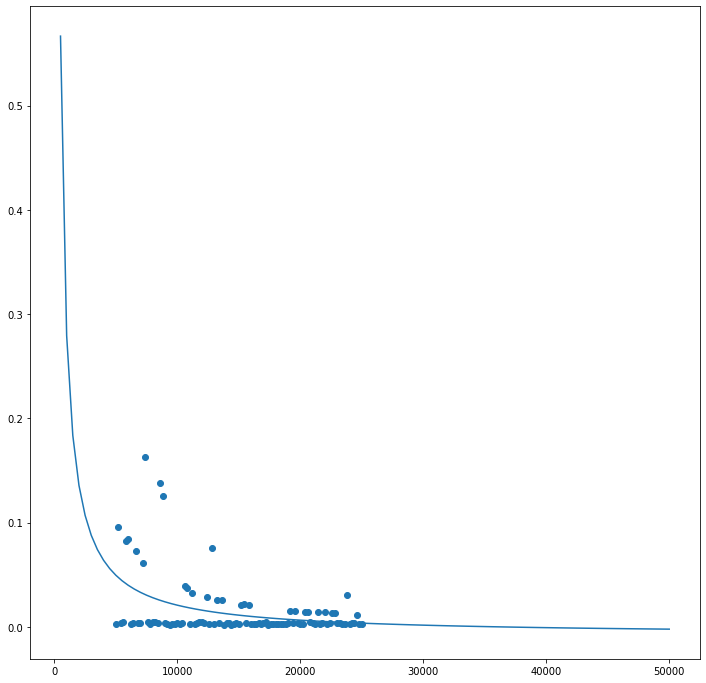

In [54]:
plt.figure(figsize=(12, 12))
plt.scatter(res[2], res[3])
plt.plot(np.linspace(0, 50_000, 101), res[0] + res[4] * (1 / np.linspace(0, 50_000, 101)))

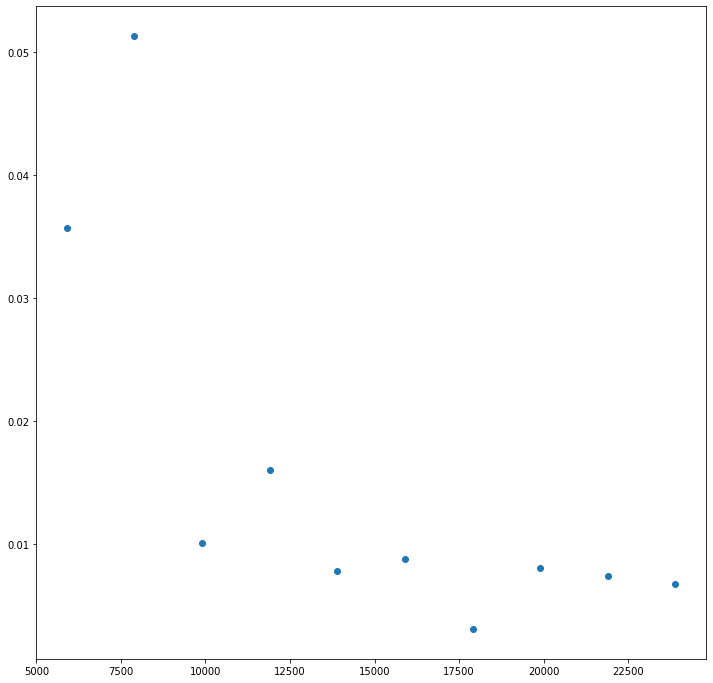

In [62]:
plt.figure(figsize=(12, 12))
plt.scatter(np.mean(res[2][:-1].reshape(-1, 10), axis=1), np.mean(res[3][:-1].reshape(-1, 10), axis=1))

<ErrorbarContainer object of 3 artists>

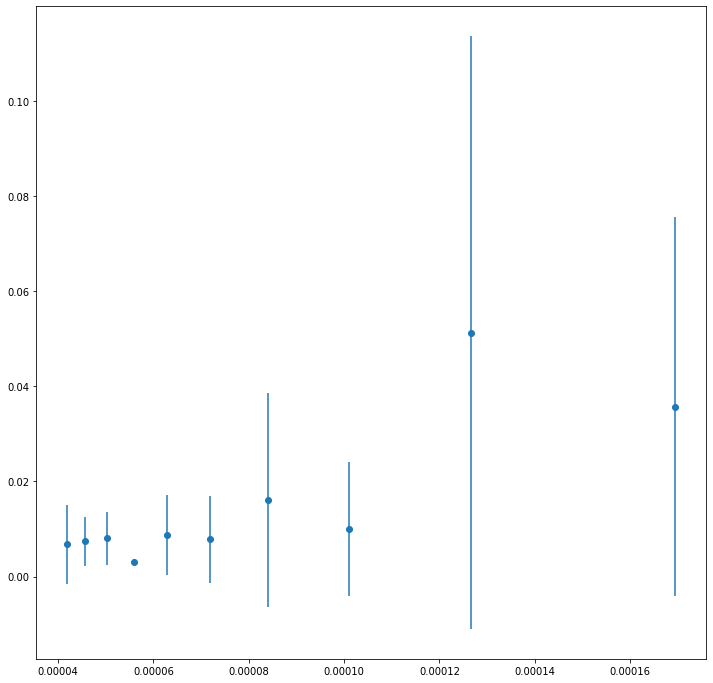

In [64]:
plt.figure(figsize=(12, 12))
plt.errorbar(1 / np.mean(res[2][:-1].reshape(-1, 10), axis=1), np.mean(res[3][:-1].reshape(-1, 10), axis=1), np.std(res[3][:-1].reshape(-1, 10), axis=1), fmt="o")

In [54]:
ms = []
for batch_size in tqdm(batch_sizes["fgd"][9:]):
    mean_std, timing = gen_metrics.multi_batch_evaluation(
        real_efps,
        gen_efps,
        5,
        batch_size,
        gen_metrics.frechet_gaussian_distance,
        timing=True,
        normalise=True
    )
    ms.append(mean_std)

100%|██████████| 9/9 [00:00<00:00, 12.89it/s]
